A variational autoencoder is a type of autoencoder with added constraints on the encoded representations being learned

 it is an autoencoder that learns a latent variable model for its input data. So instead of letting your neural network learn an arbitrary function, you learn the parameters of a probability distribution modeling your data. If you sample points from this distribution, you can generate new input data samples. This is the reason why variational autoencoders are considered to be generative models

VAEs attempt to make sure that encodings that come from some known
probability distribution can be decoded to produce reasonable outputs, even if they are not encodings of actual images.

Autoencoders basically use an encoder and decoder layer at a minimum to reduce the input data features into a latent representation by the encoder layer. The decoder expands the latent representation to generate the output with the goal of training the model well enough to reproduce the input as the output. Any discrepancy between the input and output could signify some sort of abnormal behavior or deviation from what is normal, otherwise known as anomaly detection.

In variational autoencoders, instead of mapping the input to a
fixed vector, we map the input to a distribution so the big difference is that the bottleneck vector seen in the normal order in quarters is replaced with the mean vector and a standard deviation vector by looking at the distributions and then taking the sampled latent vector as the actual bottleneck. 

First, an encoder network turns the input sample x into two parameters in a latent space, which you can call z_mean and z_log_sigma. Then, you randomly sample similar points z from the latent normal distribution that is assumed to generate the data,

via z = z_mean + exp(z_log_sigma) * epsilon, 

where epsilon is a random normal tensor. Finally, a decoder network maps these latent space points back to the original input data.

The parameters of the model are trained via two loss functions: a reconstruction loss forcing the decoded samples to match the initial inputs (just like in the previous autoencoders), and the KL divergence between the learned latent distribution and the prior distribution, acting as a regularization term.

Since you are only taking a sample of the distribution from the mean vector and the standard deviation, it is harder to realize backpropagation there. You are sampling it so how do you get back during the back propagation step?

A variational autoencoder is a kind of a mix of neural networks and graphical models since the first paper came up on variational autoencoder tried to create a graphical model and then turn the graphical model to a neural network. The variational auto encoder is based on variational inference.

The best way to understand the need for a variational autoencoder is that in a general autoencoder, the bottleneck is too dependent on the inputs and there is no understanding of the nature of the data. Since you use sampling of the distribution instead, you will be able to better accommodate the model to new types of data.

# Library

In [1]:
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

In [3]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


Bad key text.latex.unicode in file E:\programs\python\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file E:\programs\python\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file E:\programs\python\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.

In [4]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(f'E:\gitlab\custom-script\script')
from ursar import describe,scoring,fe,anomaly_detection

%reload_ext autoreload

# Load data

In [5]:
filePath = f'E:/gitlab/machine-learning/dataset/creditcard.csv'
df = pd.read_csv(filepath_or_buffer=filePath, header=0, sep=',')
print(df.shape[0])
df.head()

284807


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df0 = df.query('Class == 0').sample(20000)
df1 = df.query('Class == 1').sample(400)
df = pd.concat([df0, df1])

In [7]:
describe.vc(df,'Class')

0    20000
1      400
Name: Class, dtype: int64

# split data

In [8]:
x_train1, x_test, y_train1, y_test = train_test_split(df.drop(labels=['Time', 'Class'], axis = 1), df['Class'], test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train1, y_train1, test_size=0.2, random_state=42)
print(x_train.shape, 'train samples')
print(x_val.shape, 'validation samples')
print(x_test.shape, 'test samples')

(13056, 29) train samples
(3264, 29) validation samples
(4080, 29) test samples


# model

In [20]:
vae = anomaly_detection.model_var_autoencoder(x_train,12,2)

original dimension= 29


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 29)]         0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 12)           360         encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            26          dense_9[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            26          dense_9[0][0]                    
___________________________________________________________________

In [10]:
logfilename = "variationalautoencoder"
batch_size = 32
epochs = 20
tensorboard = TensorBoard(log_dir="logs/{}".format(logfilename),profile_batch = 100000000)

In [11]:
history = vae.fit(x_train, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_data=(x_test, x_test),
                    callbacks=[tensorboard])

Train on 13056 samples, validate on 4080 samples
Epoch 1/20
13056/13056 [==============================] - 3s 267us/sample - loss: 51.3055 - accuracy: 0.1409 - val_loss: 47.2281 - val_accuracy: 0.1581
Epoch 2/20
13056/13056 [==============================] - 2s 165us/sample - loss: 47.2019 - accuracy: 0.1686 - val_loss: 46.0874 - val_accuracy: 0.1667
Epoch 3/20
13056/13056 [==============================] - 2s 188us/sample - loss: 46.6137 - accuracy: 0.1811 - val_loss: 45.8272 - val_accuracy: 0.1797
Epoch 4/20
13056/13056 [==============================] - 2s 184us/sample - loss: 46.4550 - accuracy: 0.1903 - val_loss: 45.6928 - val_accuracy: 0.2039
Epoch 5/20
13056/13056 [==============================] - 3s 195us/sample - loss: 46.2803 - accuracy: 0.2345 - val_loss: 45.5020 - val_accuracy: 0.2632
Epoch 6/20
13056/13056 [==============================] - 2s 183us/sample - loss: 46.1254 - accuracy: 0.2987 - val_loss: 45.4037 - val_accuracy: 0.3012
Epoch 7/20
13056/13056 [===============

# evaluate

In [12]:
score = vae.evaluate(x_test, x_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4080/4080 [==============================] - 0s 89us/sample - loss: 44.7123 - accuracy: 0.3478
Test loss: 44.71232560101677
Test accuracy: 0.34779412


# calculate error

In [13]:
y_label,error = anomaly_detection.calculate_error(vae,x_test,10.00)

In [14]:
print(classification_report(y_test,y_label))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3987
           1       0.46      0.82      0.59        93

    accuracy                           0.97      4080
   macro avg       0.73      0.90      0.79      4080
weighted avg       0.98      0.97      0.98      4080



In [15]:
roc_auc_score(y_test, y_label)

0.8975662839712939

comfusion matrix = 
[[3899   88]
 [  17   76]]

accuracy_score =  0.9743
balanced_accuracy_score =  0.8976

precision score =  0.4634
average precision score =  0.3829
recall score =  0.8172

F1 score =  0.5914
F2 score =  0.5073
F3 score =  0.4844
F_beta score =  0.4844
Matthews Correlation Coefficient score =  0.6042

AUC of Precision-Recall Curve on Testing =  0.6424
Best Threshold for Precision-Recall Curve = 1.000000
F-Score = 0.591
AUC of ROC =  0.8976

Best Threshold for ROC = 1.000000
G-Mean = 0.894
Best Threshold with Youden’s J statistic = 1.000000

Cohens kappa =  0.5792
Gini =  0.2848

Expected Approval Rate =  0.0402
Expected Default Rate =  0.5366

classification_report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3987
           1       0.46      0.82      0.59        93

    accuracy                           0.97      4080
   macro avg       0.73      0.90      0.79      4080
weighted avg       0.98      0.97  

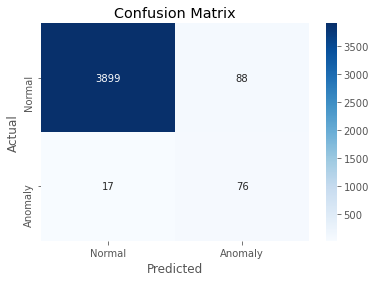

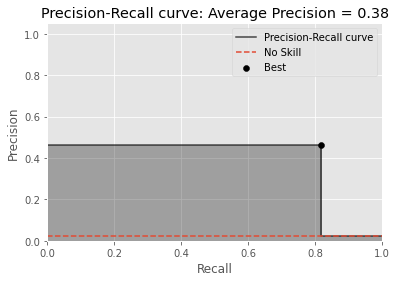

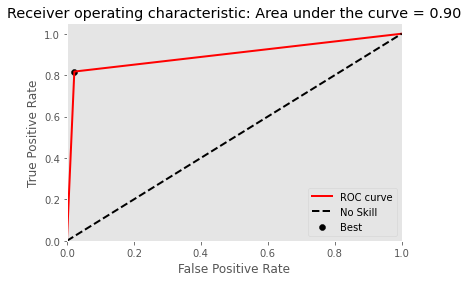


time span=  1


In [16]:
scoring.print_score(y_test,y_label,y_label,labels=["Normal", "Anomaly"])

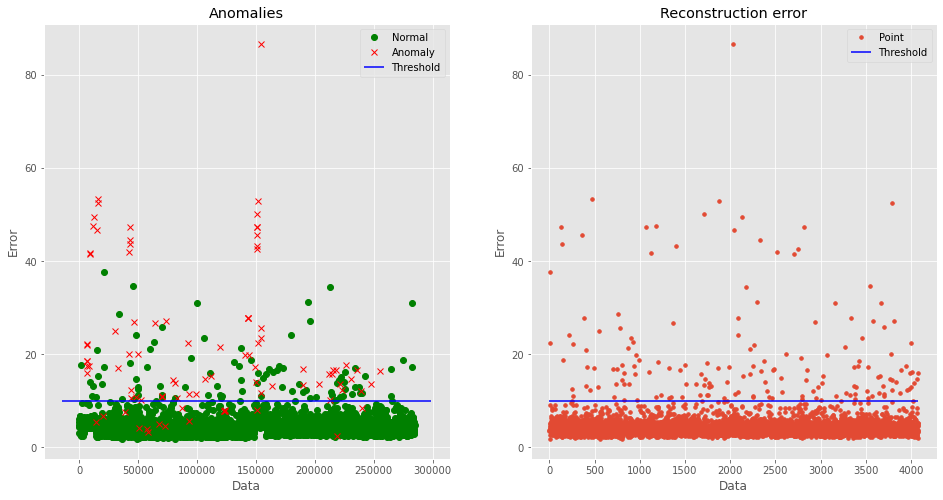

In [17]:
anomaly_detection.draw_anomaly(y_test, error, 10.00)